# Timeless Ranker With Silph API

So here I've created a little Timeless Cup team ranker based on PvPoke data from the top 30 ranked Timeless Cup mons in PvPoke.com, as well as implementing the frequency statistics from silph.gg (this part coming soon; they don't exist yet). All of this is done in Julia, but hopefully these little notes should clarify what the ranker is doing. I recommend running everything, and then reading through this. Some sections take a little bit of time to run (though mostly the inital data collection at 15ish seconds for 30 pokemon and the first histogram which can take a few minutes).

## Getting Started

### Installing Packages

Here I'm just grabbing some of the packages I need. I'll be reading from CSVs into DataFrames and making plots and using random distributions for uncertainty. Basically, I'm just grabbing some tools that make my life easier programming.

In [1]:
using CSV, Plots, DataFrames, JSON, HTTP, Distributed, SharedArrays, Distributions
gr();

### Reading Data

I've got a folder that contains all of the ranking CSVs from PvPoke, as well as the rankings JSON file. By changing individual CSVs in the folder, or updating the rankings file, we can easily modify the inputted data.

In [2]:
rankings = CSV.read("Timeless.csv")
const numMons = nrow(rankings)
rankings

,Column1,Venusaur VW+FP/SB,Dragonair DB+R/AT,Kingdra DB+O/HP
,String,Int64,Int64,Int64
1,Venusaur VW+FP/SB,500,414,589
2,Dragonair DB+R/AT,585,500,462
3,Kingdra DB+O/HP,410,537,500
4,Charizard WA+O/BB,581,255,237
5,Torkoal FS+O/E,683,217,341
6,Meganium VW+FP/PB,235,500,694
7,Lapras IS+B/S,479,640,590
8,Drapion IF+SB/FS,651,558,554
9,Muk PJ+GS/AS,500,310,513


### Colors

Just defining some colors so that things look pretty. However, there aren't cup typings this time, so its fairly arbitrary as to which typing I choose to determine the color of each mon. For Alolan Ninetales, for instance, I think of ice first, and thus that is the color of Alolan Ninetales in this model. Feel free to change these around as you feel, but given that they are primarily an aesthetic choice, I elected to not put a whole lot of thought into which color each mon gets.

In [3]:
opacity = 0.7
grass = RGBA(94/255,189/255,91/255, opacity); dragon = RGBA(14/255,104/255,184/255, opacity); dark = RGBA(86/255,86/255,99/255, opacity); normal = RGBA(153/255,159/255,161/255, opacity); fire = RGBA(254/255,163/255,84/255, opacity); ground = RGBA(212/255,141/255,91/255, opacity); poison = RGBA(193/255,98/255,212/255, opacity); rock = RGBA(208/255,196/255,142/255, opacity); ghost = RGBA(89/255,107/255,181/255, opacity); psychic = RGBA(245/255,126/255,121/255, opacity); ice = RGBA(120/255,212/255,192/255, opacity); water = RGBA(86/255,158/255,222/255, opacity); fighting = RGBA(213/255,63/255,91/255, opacity); steel = RGBA(82/255,142/255,160/255, opacity); fairy = RGBA(240/255,152/255,228/255, opacity); flying = RGBA(148/255,171/255,225/255, opacity); bug = RGBA(158/255,195/255,49/255, opacity); electric = RGBA(246/255,215/255,75/255, opacity);

### Silph API

API with frequency statistics accessed from and courtesy of silph.gg. Please do not use more than ten times per ten minutes.

In [8]:
const gamemaster = JSON.parsefile("gamemaster.json")
const cpm = CSV.read("CPM.csv"; delim=',');
url = "https://silph.gg/api/cup/timeless/stats/.json"
resp = HTTP.get(url)
const data = JSON.parse(String(resp.body))
monnames = collect(keys(data["all1Week"]))
numSilphMons = length(data["all1Week"])
silphKeys = collect(keys(data["all1Week"]))
for i = 1:numSilphMons
    name = monnames[i]
    nameArray = split(name, "-")
    if length(nameArray) > 1
        monnames[i] = titlecase(nameArray[1]) * " (" * titlecase(nameArray[2]) * ")"
    else
        monnames[i] = titlecase(name)
    end
end

In [9]:
monnames = setdiff(monnames, ["Magcargo", "Bellossom", "Blastoise", "Castform (Snowy)", "Dusclops", "Flygon"])

45-element Array{String,1}:
 "Whiscash"        
 "Charizard"       
 "Meganium"        
 "Lapras"          
 "Venomoth"        
 "Castform (Sunny)"
 "Politoed"        
 "Raichu"          
 "Drapion"         
 "Piloswine"       
 "Quagsire"        
 "Beedrill"        
 "Gloom"           
 ⋮                 
 "Venusaur"        
 "Ivysaur"         
 "Blaziken"        
 "Sceptile"        
 "Leafeon"         
 "Sudowoodo"       
 "Abomasnow"       
 "Lanturn"         
 "Spiritomb"       
 "Shiftry"         
 "Skuntank"        
 "Torkoal"         

In [27]:
silphKeys = setdiff(silphKeys, ["magcargo", "bellossom", "blastoise", "castform-snowy", "dusclops", "flygon"])

45-element Array{String,1}:
 "whiscash"      
 "charizard"     
 "meganium"      
 "lapras"        
 "venomoth"      
 "castform-sunny"
 "politoed"      
 "raichu"        
 "drapion"       
 "piloswine"     
 "quagsire"      
 "beedrill"      
 "gloom"         
 ⋮               
 "venusaur"      
 "ivysaur"       
 "blaziken"      
 "sceptile"      
 "leafeon"       
 "sudowoodo"     
 "abomasnow"     
 "lanturn"       
 "spiritomb"     
 "shiftry"       
 "skuntank"      
 "torkoal"       

In [10]:
function get_name(i)
    @inbounds name = split(rankings[i, 1], " ")[1]
    @inbounds if startswith(split(rankings[i, 1], " ")[2], "(")
        @inbounds name = name * " " * split(rankings[i, 1], " ")[2]
    end
    return name
end

get_name (generic function with 1 method)

In [37]:
function get_silph_name(i)
    name = get_name(i)
    name = lowercase(name)
    name = replace(name, "(" => "")
    name = replace(name, ")" => "")
    name = replace(name, " " => "-")
    if name == "gastrodon-west"
        name = "gastrodon-west-sea"
    end
    return name
end

get_silph_name (generic function with 1 method)

### Team Numbers

Here I'm mapping the 3 mon teams to a number, such that each team has its own unique number from 1 to 12180 ($\frac{30 \cdot 29 \cdot 28}{2}$)

In [11]:
const m = Matrix{Int64}[[mon1 mon2 mon3] for mon1 = 1:numMons, mon2 = 1:numMons, mon3 = 1:numMons if mon1 != mon2 && mon1 != mon3 && mon2 < mon3 && get_name(mon1) in monnames && get_name(mon2) in monnames && get_name(mon3) in monnames];
@eval @everywhere const m=$m

In [12]:
const numTeams = length(m)
@eval @everywhere const numTeams=$numTeams

In [13]:
teamNumberVar = zeros(numMons, numMons, numMons)
@simd for i = 1:numTeams
    @inbounds teamNumberVar[m[i][1], m[i][2], m[i][3]] = Int(i)
end
const teamNumber = teamNumberVar;

### Setting Up the Tables

I'm grabbing just the data I need and putting it in a constant (for SPEED) matrix, and also defining a matrix to store the outputs in.

In [14]:
# clean up ranking data for simulation
# Defining as constant for SPEED
const ranks = [rankings[i, j] for i = 1:numMons, j = 2:(numMons + 1)];
@eval @everywhere const ranks=$ranks
teamBattles = SharedArray{Float64}(numTeams, numTeams, init = true);
@eval @everywhere teamBattles=$teamBattles
#teamBattlesWeighted = zeros(numTeams, numTeams);

## The Model

### Assumptions

So, we all know assumptions are bad. But in data science, sometimes our models need to be simplified so we can work with the information that we have in a reasonable time scale. Therefore, I have made some simplifying assumptions for the model of PvP battles, and will add some uncertainty to account for some of the differences between this model and the reality of PvP battling.

*   **No Switching:** Switching is a weird mechanic for which the timing is never consistent, when and if you should use it in scenario X is hotly debated, and then your opponent switches, which is a lot of variability. As will be a pretty common motivator among all of these reasons, if I have the home team switch perfectly, it involves some knowledge of the opposing team that you don't have in that situation. All of this to say, for this model, nobody switches because it makes everything work better, my life easier, and doesn't run the risk of having the model make decisions better than any player could be expected to. 

*   **Each Mon Gets One Shield:** I know, I know. Doesn't that add up to three shields? Well, yeah. But again, shielding choices add in some variability, and perfect use involves some knowledge of the opposing team that you don't have in that situation. Plus, then one data set is needed, the 1-1 shield matchups from PvPoke, which I believe also implicitly have the shield used on the first charged move. 

*   **Players Play Perfectly Otherwise:** Whoa. In all that avoidance of perfection, now I want my model to be perfect? Well, for one, this is just based on the assumptions in PvPoke. For two, I stand by that decision, as its perfection that's acheivable by the knowledge a player has in a particular situation. You may not know when to shield or switch, but you do probably know that you want an excellent charged move and to tap out fast moves (also I'm assuming everyone is on 1.57 or higher, because I do not want to deal with under or overtapping). Also, this model assumes the ideal moveset for each mon (though you can change that by changing the CSVs.

*   **Putting a Mon in the Second Position is the Same as Putting it in the Third:** I think this assumption is generally accurate. I think I've seen arguments for putting the fast switch in the third position, but I'm also assuming players play perfectly and there's no switching, so I genuinely think this doesn't affect the model, but I'm including it anyway.

*   **Mons Appear Uniformly Among the Top 30 Mons:** Sorry, Spoink fans. This is to keep the amount of data this processes to a reasonable amount. There is another version of this model that uses the Silph distribution instead, however, Silph data does not exist for the Ferocious Cup yet.

*   **Score Above 1500 is a Win:** This is based on the PvPoke battle score, and since there are three battles, its out of 3000 instead of 1000. Scoring is explained more below, but this is the assumption of what we do with that score. 

None of these assumptions are set in stone. In fact, if you have a way to change them and think that that's more useful to you, 1) go ahead and 2) let me know how you did it. 

### Scoring

I know, this section is already too long, just show you the data. But here's what the data means. Each PvPoke battle is given a score of 0-1000 with 500 representing a tie, and above that being a win, below that a loss. The score for the three-mon battle is adding those three scores together. But, that depends on which matchups you see. The lead pokemon always face each other. If your lead wins, you get the favorable matchups (because your opponent had to put in a pokemon and you can counter it), if your lead loses, you get the less favorable matchups. And, as stated above, over 1500 is a win.

In [15]:
@everywhere function individual_battle_verbose(home1::Int64,home2::Int64,home3::Int64,away1::Int64,away2::Int64,away3::Int64)
    
    @fastmath             score  = 1000 - ranks[away1, home1]
    @fastmath secondBattleResult1 = 1000 - ranks[away2, home2]
    @fastmath secondBattleResult2 = 1000 - ranks[away3, home2]
    @fastmath thirdBattleResult1  = 1000 - ranks[away2, home3]
    @fastmath thirdBattleResult2  = 1000 - ranks[away3, home3]

    if score > 500 
        @fastmath score += max(secondBattleResult2 + thirdBattleResult1, secondBattleResult1 + thirdBattleResult2) 
    elseif score < 500 
        @fastmath score += min(secondBattleResult2 + thirdBattleResult1, secondBattleResult1 + thirdBattleResult2) 
    else
        @fastmath score += (secondBattleResult2 + thirdBattleResult1 + secondBattleResult1 + thirdBattleResult2)/2.0 
    end 
    
    return score
    
end;

### Testing

The timing stuff is mostly for me, to make sure things can run in a reasonable time. But they exist and they're here in case you're curious

In [16]:
individual_battle_verbose(1, 2, 3, 1, 2, 3)
@time individual_battle_verbose(1, 2, 3, 1, 2, 4)

  0.000002 seconds (5 allocations: 176 bytes)


1773.0

In [17]:
@everywhere function run_away_teams_verbose(i::Int64, mon1::Int64, mon2::Int64, mon3::Int64)
    @simd for j = 1:numTeams
        # Do the battle!
        # Use the function we wrote above
        @inbounds teamBattles[j, i] = individual_battle_verbose(m[j][1],m[j][2],m[j][3], mon1,mon2,mon3)
    end
end

In [18]:
run_away_teams_verbose(2, 4, 1, 2)
@time run_away_teams_verbose(1, 3, 1, 2)

  0.002188 seconds (78.96 k allocations: 1.205 MiB)


### Testing a Team

This function does all possible teams against a certain team. And there are two versions, depending on if you want verbose output.

In [19]:
function run_home_teams_verbose()
    @sync @distributed for i = 1:numTeams
        @inbounds run_away_teams_verbose(i,m[i][1],m[i][2],m[i][3])
    end
end;

In [20]:
# Run once to compile, run again to test speed 
run_home_teams_verbose()
@time run_home_teams_verbose();

 83.240157 seconds (4.69 G allocations: 69.923 GiB, 4.13% gc time)


In [21]:
teamBattles

39732×39732 SharedArray{Float64,2}:
 1500.5  1764.0  1660.0  1306.0  1410.0  …  1994.0  1819.0  1631.0  1468.0
 1238.0  1500.5  1570.0  1745.0  1182.0     1313.0  1715.5  1540.0  2029.0
 1342.0  1432.0  1500.5  1738.0  1415.0     1434.0  1578.0  2011.0  1847.0
 1696.0  1257.0  1264.0  1500.5  1606.0     2118.0  1954.0  1366.0  1950.0
 1592.0  1820.0  1587.0  1396.0  1500.5     1533.0  1616.0  1850.0  1324.0
 1556.0  1453.0  1283.0  1716.0  1204.0  …  1381.0  1937.0  1874.0  1928.0
 1515.0  1483.0  1378.0  1696.0  1336.0     1381.0  1446.0  1934.0  1984.0
 1555.0  1540.0  1344.0  1772.0  1432.0     1605.0  1419.0  2041.0  2041.0
 1654.0  1604.0  1436.0  1526.0  1511.0     1852.0  1563.0  1898.0  1324.0
 1636.0  1755.0  1447.0  1701.0  1418.0     1624.0  2089.0  1874.0  1980.0
 1355.0  1304.0  1747.0  1576.0  1468.0  …  1385.0  1510.0  1343.0  1848.0
 1558.0  1253.0  1256.0  1649.0  1555.0     2081.0  1835.0  1377.0  2028.0
 1392.0  1670.0  1640.0  1500.5  1640.0     1536.0  1385.0  2067

### Summary Stats

Here I'm going to save the summary stats for every team, where my summary stats are the number of wins, and the mean, variance, skewness, and kurtosis of the scores. 

In [57]:
summaryStats = zeros(numTeams, 8)
@simd for i = 1:numTeams
    numWins = 0.0
    avgScore = 0.0
    @simd for j = 1:numTeams
        @inbounds @fastmath weight = data["all1Week"][get_silph_name(m[i][1])]["percent"] / 100.0
        @inbounds @fastmath weight *= data["all1Week"][get_silph_name(m[i][2])]["percent"] / 100.0
        @inbounds @fastmath weight *= data["all1Week"][get_silph_name(m[i][3])]["percent"] / 100.0
        @fastmath weight /= 3.0
        @inbounds @fastmath avgScore += teamBattles[i, j] * weight
        @inbounds @fastmath if teamBattles[i, j] > 1500
            @fastmath numWins += 100.0 * weight
        end
    end
    print(".")
    @fastmath avgScore /= numTeams
    team = teamBattles[i,:]
    summaryStats[i, :] = [numWins avgScore var(team) skewness(team) kurtosis(team) m[i][1] m[i][2] m[i][3]]
end        

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

## Number of Wins

Here we've got the information related to the number of wins. Below is a histogram of the number of teams vs their number of wins, a sorted list that shows the best and worst teams by number of wins, and a histogram comparing the scores of the best and worst teams by number of wins.

In [81]:
for i = 1:numTeams
    summaryStats[i, 1] /= (numTeams / 100.0)
end

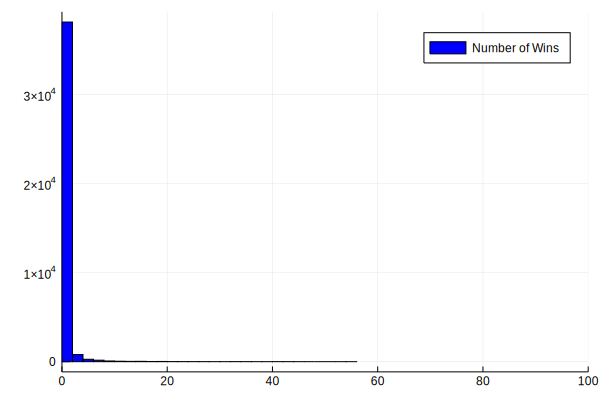

In [84]:
histogram(summaryStats[:, 1], bins = 50, label = "Number of Wins", color = :blue, xlims = (0, 100))

In [85]:
sumStatsNumWins = sortslices(summaryStats, by=x->x[1], dims = 1, rev = true)

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = rankings[Int(sumStatsNumWins[i, 6]),1]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = rankings[Int(sumStatsNumWins[i, 7]),1]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = rankings[Int(sumStatsNumWins[i, 8]),1]
end

teamNumbers = zeros(numTeams)
for i = 1:numTeams
    teamNumbers[i] = Int(teamNumber[Int(sumStatsNumWins[i, 6]), Int(sumStatsNumWins[i, 7]), Int(sumStatsNumWins[i, 8])])
end

sumStatsNumWins = hcat(sumStatsNumWins, names1)
sumStatsNumWins = hcat(sumStatsNumWins, names2)
sumStatsNumWins = hcat(sumStatsNumWins, names3)
sumStatsNumWins = hcat(sumStatsNumWins, teamNumbers)

sumStatsNumWins = DataFrame(sumStatsNumWins)

rename!(sumStatsNumWins, Symbol("x1")=>Symbol("Win %"))
rename!(sumStatsNumWins, Symbol("x2")=>Symbol("Avg Score"))
select!(sumStatsNumWins, Not(:x3))
select!(sumStatsNumWins, Not(:x4))
select!(sumStatsNumWins, Not(:x5))
select!(sumStatsNumWins, Not(:x6))
select!(sumStatsNumWins, Not(:x7))
select!(sumStatsNumWins, Not(:x8))
rename!(sumStatsNumWins, Symbol("x9")=>Symbol("Mon 1"))
rename!(sumStatsNumWins, Symbol("x10")=>Symbol("Mon 2"))
rename!(sumStatsNumWins, Symbol("x11")=>Symbol("Mon 3"))
rename!(sumStatsNumWins, Symbol("x12")=>Symbol("Team Number"));

sumStatsNumWins

,Win %,Avg Score,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any
1,55.8084,12.6426,Dragonair DB+R/AT,Kingdra DB+O/HP,Lapras IS+B/S
2,52.1863,12.4156,Lapras IS+B/S,Dragonair DB+R/AT,Kingdra DB+O/HP
3,45.2256,10.1898,Dragonair DB+R/AT,Lapras IS+B/S,Sealeo PS+BS/AB
4,44.2866,10.1084,Dragonair DB+R/AT,Kingdra DB+O/HP,Sealeo PS+BS/AB
5,43.8086,10.2424,Dragonair DB+R/AT,Lapras IS+B/S,Whiscash MS+B/MB
6,43.239,10.0622,Dragonair DB+R/AT,Kingdra DB+O/HP,Whiscash MS+B/MB
7,42.6151,10.1143,Lapras IS+B/S,Dragonair DB+R/AT,Sealeo PS+BS/AB
8,42.5712,12.0753,Kingdra DB+O/HP,Dragonair DB+R/AT,Lapras IS+B/S
9,42.4428,10.076,Sealeo PS+BS/AB,Dragonair DB+R/AT,Lapras IS+B/S


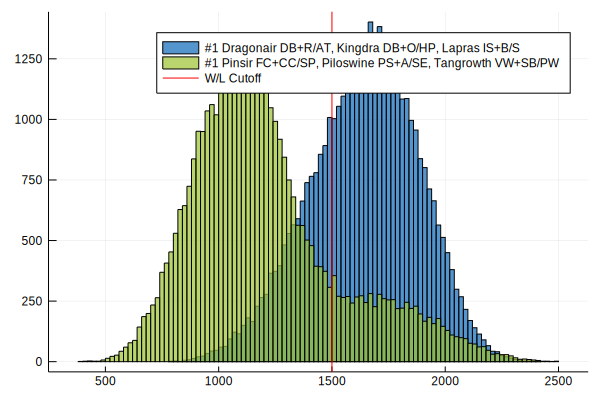

In [91]:
histogram(teamBattles[Int(sumStatsNumWins[1, 6]),:], bins = 100, color = dragon, label = "#1 " * sumStatsNumWins[1, 3] * ", " * sumStatsNumWins[1, 4] * ", " * sumStatsNumWins[1, 5])
histogram!(teamBattles[Int(sumStatsNumWins[numTeams, 6]),:], bins = 100, color = bug, label = "#1 " * sumStatsNumWins[numTeams, 3] * ", " * sumStatsNumWins[numTeams, 4] * ", " * sumStatsNumWins[numTeams, 5])
vline!([1500], color = :red, label = "W/L Cutoff")

Here we've got the number of wins on average in every team a particular pokemon is a part of and rank them below, again showing the best and worst.

In [71]:
avgNumOfWins = zeros(numMons, 2)
for i = 1:numTeams
    avgNumOfWins[m[i][1], 1] += summaryStats[i, 1]
    avgNumOfWins[m[i][2], 1] += summaryStats[i, 1]
    avgNumOfWins[m[i][3], 1] += summaryStats[i, 1]
end
for i = 1:numMons
    avgNumOfWins[i, 2] = i
    d = x -> (i in x)
    divisor = count(d, m)
    if divisor == 0
        divisor = 1
    end
    avgNumOfWins[i, 1] /= (divisor * numTeams / 100.0)
end

avgNumOfWinsSorted = sortslices(avgNumOfWins, by=x->x[1], dims = 1, rev = true)

nameNumWins = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameNumWins[i, 1] = rankings[Int(avgNumOfWinsSorted[i, 2]), 1]
end

avgNumOfWinsSorted = hcat(avgNumOfWinsSorted, nameNumWins)

avgNumOfWinsSorted = DataFrame(avgNumOfWinsSorted)

rename!(avgNumOfWinsSorted, Symbol("x1")=>Symbol("Win %"))
rename!(avgNumOfWinsSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgNumOfWinsSorted, Symbol("x3")=>Symbol("Name"))

,Win %,Rank,Name
,Any,Any,Any
1,2.33956,2.0,Dragonair DB+R/AT
2,1.57963,7.0,Lapras IS+B/S
3,1.43985,3.0,Kingdra DB+O/HP
4,1.29489,33.0,Sealeo PS+BS/AB
5,1.2805,36.0,Whiscash MS+B/MB
6,1.1976,19.0,Victreebel RL+LB/SB
7,1.05348,1.0,Venusaur VW+FP/SB
8,0.78825,4.0,Charizard WA+O/BB
9,0.719318,12.0,Skuntank PJ+SB/C


Here I've plotted the PvPoke ranking compared to the average number of wins. I think its not necessarily a surprise that there's not a perfect correlation here (you don't put in the top 6 ranked mons generally), but there is a pretty clear negative slope here. The big spike I think is Lickilicky.

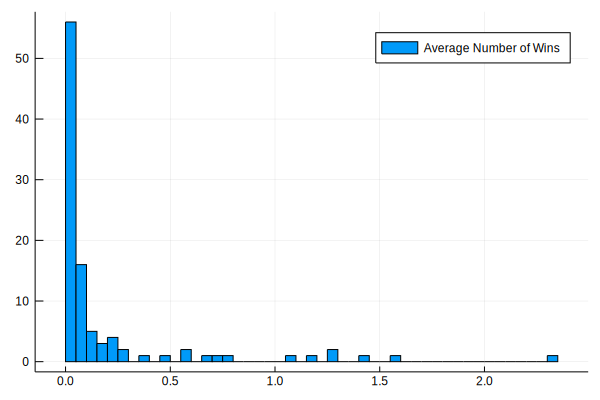

In [73]:
histogram(avgNumOfWins[:, 1], bins = 45, label = "Average Number of Wins")

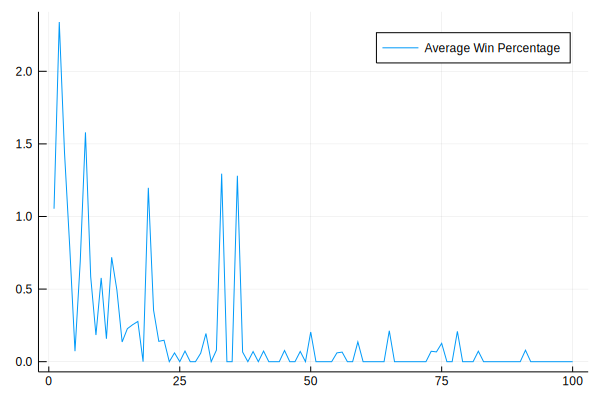

In [96]:
plot(1:numMons, avgNumOfWins[:, 1], label = "Average Win Percentage")

## Average Score

Here we've got the information related to the average. Below is a histogram of the number of teams vs their average, a sorted list that shows the best and worst teams by average score, and a histogram comparing the scores of the best and worst teams by average score. Not that there are minor differences between the average score statistics and the number of wins. I generally consider number of wins to be a more useful statistic (as it doesn't necessarily matter to me how much I win by as long as I win), but I could see arguments for using this particular statistic instead.

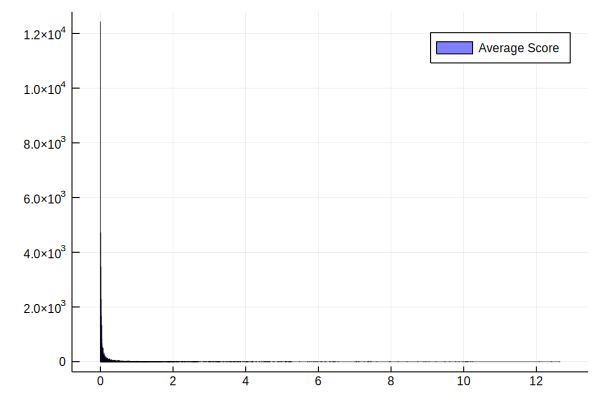

In [76]:
histogram(summaryStats[:, 2], label = "Average Score", color = :blue, alpha =0.5)

In [86]:
sumStatsAvgScore = sortslices(summaryStats, by=x->x[2], dims = 1, rev = true)

names1 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names1[i, 1] = rankings[Int(sumStatsAvgScore[i, 6]),1]
end

names2 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names2[i, 1] = rankings[Int(sumStatsAvgScore[i, 7]),1]
end

names3 = Array{String}(undef, numTeams, 1)
for i = 1:numTeams
    names3[i, 1] = rankings[Int(sumStatsAvgScore[i, 8]),1]
end

teamNumbers = zeros(numTeams)
for i = 1:numTeams
    teamNumbers[i] = Int(teamNumber[Int(sumStatsAvgScore[i, 6]), Int(sumStatsAvgScore[i, 7]), Int(sumStatsAvgScore[i, 8])])
end

sumStatsAvgScore = hcat(sumStatsAvgScore, names1)
sumStatsAvgScore = hcat(sumStatsAvgScore, names2)
sumStatsAvgScore = hcat(sumStatsAvgScore, names3)
sumStatsAvgScore = hcat(sumStatsAvgScore, teamNumbers)

sumStatsAvgScore = DataFrame(sumStatsAvgScore)

rename!(sumStatsAvgScore, Symbol("x1")=>Symbol("Win %"))
rename!(sumStatsAvgScore, Symbol("x2")=>Symbol("Avg Score"))
select!(sumStatsAvgScore, Not(:x3))
select!(sumStatsAvgScore, Not(:x4))
select!(sumStatsAvgScore, Not(:x5))
select!(sumStatsAvgScore, Not(:x6))
select!(sumStatsAvgScore, Not(:x7))
select!(sumStatsAvgScore, Not(:x8))
rename!(sumStatsAvgScore, Symbol("x9")=>Symbol("Mon 1"))
rename!(sumStatsAvgScore, Symbol("x10")=>Symbol("Mon 2"))
rename!(sumStatsAvgScore, Symbol("x11")=>Symbol("Mon 3"))
rename!(sumStatsAvgScore, Symbol("x12")=>Symbol("Team Number"));

sumStatsAvgScore

,Win %,Avg Score,Mon 1,Mon 2,Mon 3
,Any,Any,Any,Any,Any
1,55.8084,12.6426,Dragonair DB+R/AT,Kingdra DB+O/HP,Lapras IS+B/S
2,52.1863,12.4156,Lapras IS+B/S,Dragonair DB+R/AT,Kingdra DB+O/HP
3,42.5712,12.0753,Kingdra DB+O/HP,Dragonair DB+R/AT,Lapras IS+B/S
4,43.8086,10.2424,Dragonair DB+R/AT,Lapras IS+B/S,Whiscash MS+B/MB
5,45.2256,10.1898,Dragonair DB+R/AT,Lapras IS+B/S,Sealeo PS+BS/AB
6,42.6151,10.1143,Lapras IS+B/S,Dragonair DB+R/AT,Sealeo PS+BS/AB
7,44.2866,10.1084,Dragonair DB+R/AT,Kingdra DB+O/HP,Sealeo PS+BS/AB
8,42.4428,10.076,Sealeo PS+BS/AB,Dragonair DB+R/AT,Lapras IS+B/S
9,43.239,10.0622,Dragonair DB+R/AT,Kingdra DB+O/HP,Whiscash MS+B/MB


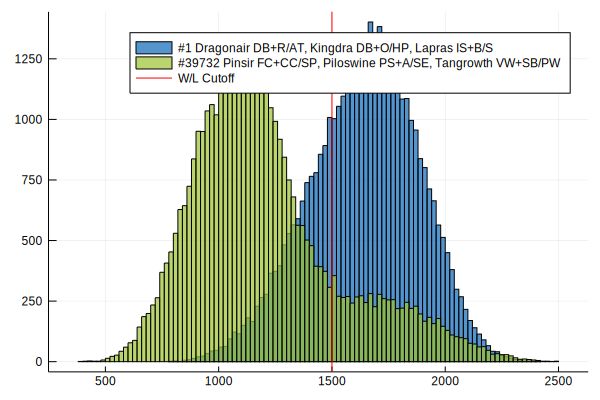

In [90]:
histogram(teamBattles[Int(sumStatsAvgScore[1, 6]),:], bins = 100, color = dragon, label = "#1 " * sumStatsAvgScore[1, 3] * ", " * sumStatsAvgScore[1, 4] * ", " * sumStatsAvgScore[1, 5])
histogram!(teamBattles[Int(sumStatsAvgScore[numTeams, 6]),:], bins = 100, color = bug, label = "#" * string(numTeams) * " " * sumStatsAvgScore[numTeams, 3] * ", " * sumStatsAvgScore[numTeams, 4] * ", " * sumStatsAvgScore[numTeams, 5])
vline!([1500], color = :red, label = "W/L Cutoff")

In [92]:
avgScore = zeros(numMons, 2)
avgScore = zeros(numMons, 2)
for i = 1:numTeams
    avgScore[m[i][1], 1] += summaryStats[i, 2]
    avgScore[m[i][2], 1] += summaryStats[i, 2]
    avgScore[m[i][3], 1] += summaryStats[i, 2]
end
for i = 1:numMons
    avgScore[i, 2] = i
    d = x -> (i in x)
    divisor = count(d, m)
    if divisor == 0
        divisor = 1
    end
    avgScore[i, 1] /= (divisor)
end

avgScoreSorted = sortslices(avgScore, by=x->x[1], dims = 1, rev = true)

nameAvgScore = Array{String}(undef, numMons, 1)
for i = 1:numMons
    nameAvgScore[i, 1] = rankings[Int(avgScoreSorted[i, 2]), 1]
end

avgScoreSorted = hcat(avgScoreSorted, nameAvgScore)

avgScoreSorted = DataFrame(avgScoreSorted)

rename!(avgScoreSorted, Symbol("x1")=>Symbol("Avg Score"))
rename!(avgScoreSorted, Symbol("x2")=>Symbol("Rank"))
rename!(avgScoreSorted, Symbol("x3")=>Symbol("Name"))

,Avg Score,Rank,Name
,Any,Any,Any
1,0.593074,2.0,Dragonair DB+R/AT
2,0.425243,7.0,Lapras IS+B/S
3,0.414118,3.0,Kingdra DB+O/HP
4,0.352114,33.0,Sealeo PS+BS/AB
5,0.349474,36.0,Whiscash MS+B/MB
6,0.317557,19.0,Victreebel RL+LB/SB
7,0.269732,1.0,Venusaur VW+FP/SB
8,0.231744,4.0,Charizard WA+O/BB
9,0.1921,12.0,Skuntank PJ+SB/C


Again, there isn't a strong correlation with the average score to the PvPoke ranking, but that is to be expected. Also, average score is strongly correlated with the number of wins, which is also to be expected. So this particular statistic is not the same as number of wins, or even leads to the same conclusion, but they are correlated.

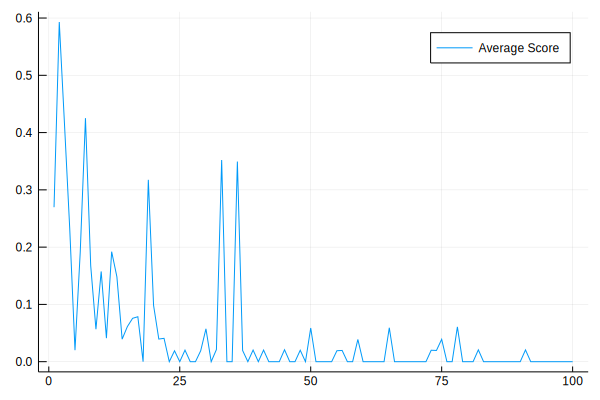

In [93]:
plot(1:numMons, avgScore[:, 1], label = "Average Score")

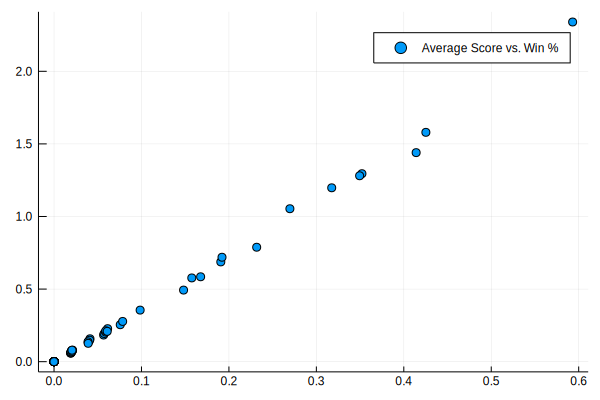

In [94]:
plot(avgScore[:, 1], avgNumOfWins[:, 1], seriestype=:scatter, label = "Average Score vs. Win %")